In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from time import time
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings; warnings.filterwarnings('ignore')
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
DATASET_DIRECTORY = '../CICIoT2023/'

In [3]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Initialize an empty DataFrame to store the concatenated data
concatenated_df = pd.DataFrame()

# Iterate through each CSV file and concatenate its contents to the DataFrame
for csv_file in tqdm(df_sets):
    file_path = os.path.join(DATASET_DIRECTORY, csv_file)
    df = pd.read_csv(file_path)
    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)

100%|██████████| 169/169 [04:33<00:00,  1.62s/it]


In [4]:
# Display the concatenated DataFrame
df = concatenated_df.copy()
print(concatenated_df.count())
df.dropna(inplace=True)
df.count()

flow_duration      14215734
Header_Length      14215727
Protocol Type      14215722
Duration           14215720
Rate               14215718
Srate              14215708
Drate              14215694
fin_flag_number    14215692
syn_flag_number    14215687
rst_flag_number    14215685
psh_flag_number    14215684
ack_flag_number    14215681
ece_flag_number    14215679
cwr_flag_number    14215678
ack_count          14215677
syn_count          14215675
fin_count          14215674
urg_count          14215671
rst_count          14215669
HTTP               14215668
HTTPS              14215667
DNS                14215665
Telnet             14215661
SMTP               14215660
SSH                14215659
IRC                14215654
TCP                14215651
UDP                14215644
DHCP               14215640
ARP                14215636
ICMP               14215635
IPv                14215632
LLC                14215631
Tot sum            14215631
Min                14215628
Max                1

flow_duration      14215577
Header_Length      14215577
Protocol Type      14215577
Duration           14215577
Rate               14215577
Srate              14215577
Drate              14215577
fin_flag_number    14215577
syn_flag_number    14215577
rst_flag_number    14215577
psh_flag_number    14215577
ack_flag_number    14215577
ece_flag_number    14215577
cwr_flag_number    14215577
ack_count          14215577
syn_count          14215577
fin_count          14215577
urg_count          14215577
rst_count          14215577
HTTP               14215577
HTTPS              14215577
DNS                14215577
Telnet             14215577
SMTP               14215577
SSH                14215577
IRC                14215577
TCP                14215577
UDP                14215577
DHCP               14215577
ARP                14215577
ICMP               14215577
IPv                14215577
LLC                14215577
Tot sum            14215577
Min                14215577
Max                1

In [5]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
        'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

X_df = df[X_columns]
y_df = df[y_column]

In [6]:
print(y_df.value_counts())

label
DDoS-ICMP_Flood            2192049
DDoS-UDP_Flood             1651277
DDoS-TCP_Flood             1369361
DDoS-PSHACK_Flood          1247051
DDoS-SYN_Flood             1235234
DDoS-RSTFINFlood           1231180
DDoS-SynonymousIP_Flood    1097522
DoS-UDP_Flood              1009108
DoS-TCP_Flood               812748
DoS-SYN_Flood               617871
BenignTraffic               333260
Mirai-greeth_flood          301804
Mirai-udpplain              271028
Mirai-greip_flood           228530
DDoS-ICMP_Fragmentation     137613
MITM-ArpSpoofing             93724
DDoS-UDP_Fragmentation       87459
DDoS-ACK_Fragmentation       87044
DNS_Spoofing                 54436
Recon-HostDiscovery          40933
Recon-OSScan                 29886
Recon-PortScan               24999
DoS-HTTP_Flood               21903
VulnerabilityScan            11431
DDoS-HTTP_Flood               8759
DDoS-SlowLoris                7161
DictionaryBruteForce          4019
BrowserHijacking              1690
SqlInjection  

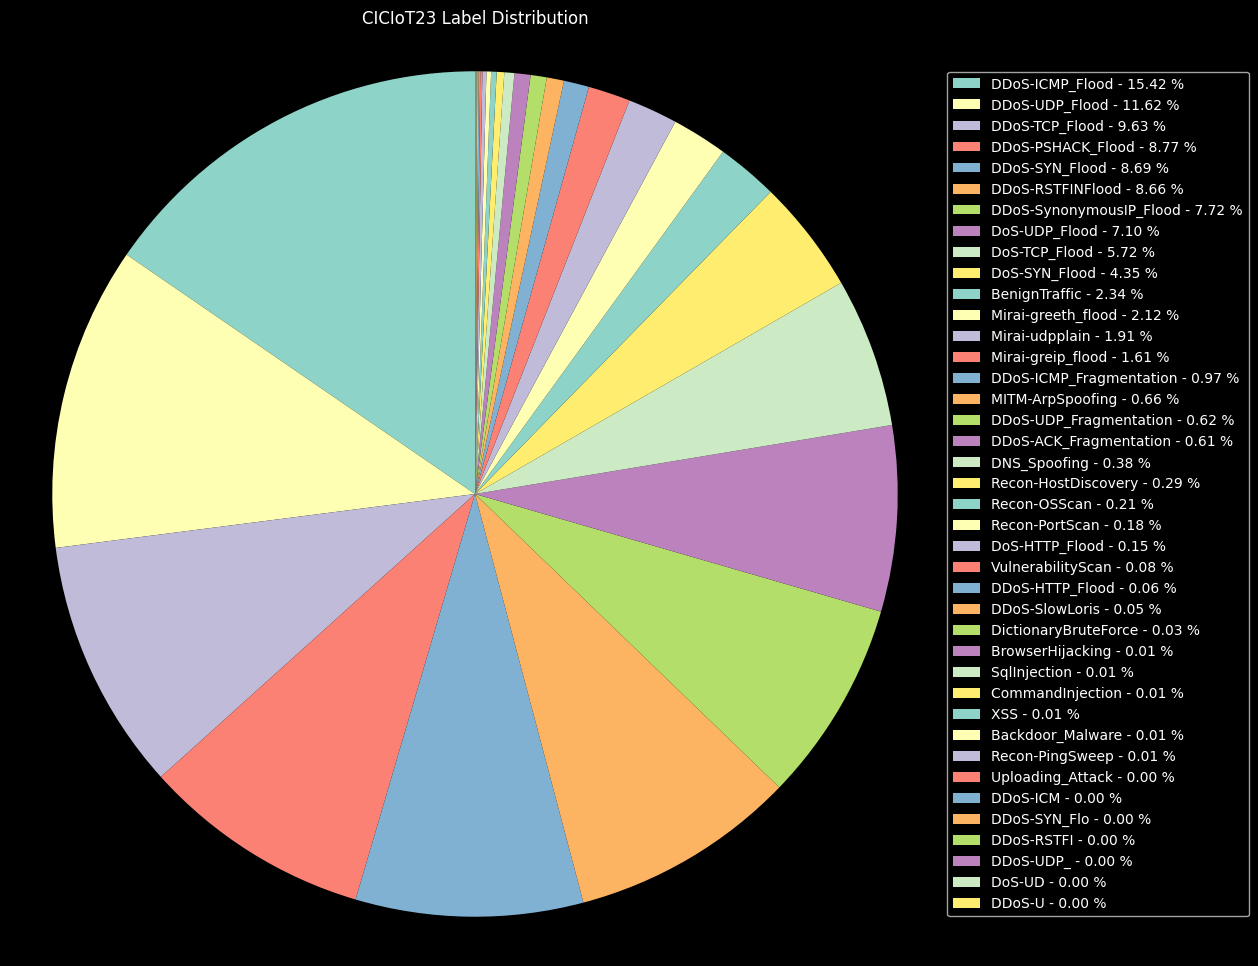

In [24]:
label_series = pd.Series(y_df.value_counts())

# Get labels and counts from the dictionary
labels = label_series.index
counts = label_series.values
percent = 100.*counts/counts.sum()

# Create a pie chart
plt.figure(figsize=(12, 12))
wedges, _ = plt.pie(counts, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.title('CICIoT23 Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig('CICIoT2023_label_dist.png', bbox_inches='tight')
plt.show()

# Binary Classification

In [8]:
y_df_binary = y_df.apply(lambda x: 'attack' if x != 'BenignTraffic' else x)
y_df_binary.value_counts()

label
attack           13882317
BenignTraffic      333260
Name: count, dtype: int64

In [9]:
scaler = MinMaxScaler()

scaled_df = X_df.copy()
for column in X_df.columns:
    column_data = X_df[column].values.reshape(-1, 1)
    scaled_df[column] = scaler.fit_transform(column_data)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y_df_binary, test_size=0.2, random_state=42)

In [17]:
#Training a classifier
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 1453.221 seconds.


In [18]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 105.026 seconds.
Classifier predicted on test set in 24.562 seconds.
Accuracy train:  0.9999995603414248
Accuracy test:  0.9976318236751508
Precision:  0.9976318236751508
Recall:  0.9976318236751508
F1 Score:  0.9976318236751508


# Non-Binary Classification

In [19]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y_df, test_size=0.2, random_state=42)

In [20]:
#Training a classifier
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

KeyboardInterrupt: 

In [ ]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

# PCA

In [2]:
pca = PCA().fit(scaled_df)

fig, ax = plt.subplots( figsize=(15, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis for Digits Dataset')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()

# Find the index where cumulative explained variance first exceeds 95%
index_95_percent = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95)

# Add a marker at the 95% point
plt.scatter(index_95_percent, 0.95, color='r', marker='o')

# Annotate the point with text
plt.annotate(f'{index_95_percent+1} components\n95% explained variance',
             xy=(index_95_percent, 0.95), xytext=(index_95_percent+20, 0.92),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

NameError: name 'PCA' is not defined

In [30]:
pca = PCA(n_components=index_95_percent)
pca_result = pca.fit_transform(scaled_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, y_df, test_size=0.2, random_state=42)

In [ ]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

In [ ]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Optimal number of components: ", index_95_percent)

# Selecting best features

In [ ]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder on the labels and transform the column
y_encoded = label_encoder.fit_transform(y_df)

In [ ]:
# Define a list of percentiles to test
percentiles = [10, 20, 30, 40, 50]

# Create a pipeline with feature selection and your classifier
model = make_pipeline(SelectPercentile(score_func=f_classif), RandomForestClassifier())

# Store accuracies for each percentile
accuracies = []

# Perform cross-validation for each percentile
for percentile in tqdm(percentiles):
    model.set_params(selectpercentile__percentile=percentile)
    scores = cross_val_score(model, scaled_df, y_encoded, cv=5)
    accuracies.append(scores.mean())

# Print accuracies for each percentile
for percentile, accuracy in zip(percentiles, accuracies):
    print(f"Percentile: {percentile}, Mean Accuracy: {accuracy}")

In [ ]:
selector = SelectPercentile(score_func=f_classif, percentile=30)

# Fit and transform the training set
X_selected = selector.fit_transform(scaled_df, y_encoded)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y_encoded, test_size=0.2, random_state=42)

In [ ]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

In [ ]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("% feature selected", optimal_percentile)

# RFECV

In [ ]:
# Select at least 10% of the features
num_columns = len(kdd_df.columns)
min_features_to_select = int(num_columns * 0.1)

clf = RandomForestClassifier()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=4,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(features, labels)

print(f"Optimal number of features: {rfecv.n_features_}")

In [ ]:
selected_feature_indices = rfecv.support_
selected_feature_names = [num_features[i] for i, selected in enumerate(selected_feature_indices) if selected]

print("Selected Features:", selected_feature_names)

reduced_df = features[selected_feature_names]

In [ ]:
# Fit and transform the training set
#X_selected = selector.fit_transform(reduced_df, labels)
X_train, X_test, y_train, y_test = train_test_split(reduced_df, labels, test_size=0.2, random_state=42)

In [ ]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

In [ ]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("N features selected", len(reduced_df.columns))

In [10]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

encoded_binary_labels = y_df_binary.copy()

# Fit the encoder on the labels and transform the column
encoded_binary_labels = label_encoder.fit_transform(encoded_binary_labels)

In [ ]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=(len(scaled_df.columns)//2), random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df))
df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(scaled_df, df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 5

plt.figure(figsize=(15, 7))
plt.plot(scores)
#plt.plot(encoded_binary_labels, alpha=0.5, color='red')# Larger figure size
# Plot bars only where y_encoded is 5
for i, val in enumerate(encoded_binary_labels):
    if val == 5:
        plt.bar(i, val, color='red', alpha=0.5)
plt.savefig('../images/NIDS_V1_pca_vs_read.png')
plt.show()